# Import Libraries

In [1]:
# import web driver
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from seleniumrequests import Chrome

from bs4 import BeautifulSoup
import requests
import time
import random
import re
import getpass
import os
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score


%matplotlib inline 

# Crime Data - Clean and Aggregate

#### Clean Crime Data and Save to 'chicago_crime_cleaned_aggregated.csv'

In [2]:
# # Preprocessing Chicago Crime Data

# # Import Chicago Crime Data : Source : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
# df_crime = pd.read_csv("chicago_crime.csv")

# # Convert text date to datetime
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['Date'],format="%m/%d/%Y %I:%M:%S %p", errors = 'coerce')

# # Strip hr, min, sec data so that aggregation per day is possible
# df_crime['DATE_TIME_TRUN'] = df_crime['DATE_TIME'].map(lambda x: x.strftime('%Y-%m-%d'))

# # Drop unneeded columns
# df_crime = df_crime[['ID','DATE_TIME_TRUN']].copy()

# # Just get the date and total crime count and create new df after aggregating by single day
# df_crime = df_crime.groupby(['DATE_TIME_TRUN'],as_index = False).count().copy()

# # Save cleaned data
# with open('chicago_crime_cleaned_aggregated.pkl', 'wb') as picklefile:
#     pickle.dump(df_crime, picklefile)


#### Load Cleaned & Aggregated Crime Data and Few More Tweaking

In [4]:
# # Load data
# with open('data/chicago_crime_cleaned_aggregated.pkl', 'rb') as picklefile: 
#     df_crime = pickle.load(picklefile)

# # Turn DATE_TIME back to datetime dtype
# df_crime['DATE_TIME'] = pd.to_datetime(df_crime['DATE_TIME_TRUN'])
# df_crime['YEAR_MONTH'] = df_crime['DATE_TIME_TRUN'].apply(lambda x:x[:-3])

# # Remove Crime Data Outside Available Weather Data
# df_crime = df_crime[df_crime['DATE_TIME_TRUN']>'2009-09-01'] 

# # Rename Columns to Make Them More Intuitive and for Later Merging with Weather Data
# df_crime.rename(columns={'ID':'CRIME_COUNT','DATE_TIME':'DATE_TIME_PROCESSED'}, inplace=True)

# Weather Data -  Scraping

#### (Testing) scroll length 

In [4]:
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(2,2010)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

#### Web scraping function

In [5]:
# def scrape_weather_url(url):
#     # weather data holder to be inserted to pandas dataframe
#     high_low, weather_desc, humidity_barometer, wind, date_time = [], [], [], [], []
    
#     # open url
#     driver.get(url)
#     soup = BeautifulSoup(driver.page_source, "lxml")
#     days_chain = [x.find_all('a') for x in soup.find_all(class_='weatherLinks')]
#     time.sleep(5)
    
#     # Load Entire Page by Scrolling to charts
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight/3.5);") # Scroll down to bottom
    
#     # First load of each month takes extra long time. Therefore 'counter' variable is used to run else block first
#     counter = 0
#     for ix,link in enumerate(days_chain[0]):
        
#         '''
#         Bottom section tries to solve loading issue by implementing wait feature
#         Refer : https://selenium-python.readthedocs.io/waits.html
#         '''
#         wait = WebDriverWait(driver, 10)
#         if counter!=0:
#             delay = 3 # seconds
#             try:
#                 myElem = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
#             except TimeoutException:
#                 print("Loading took too much time!" ) 
#             day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
#             wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
#             day_link.click()
#         else:
#             delay = 5 # seconds
#             try:
#                 myElem = WebDriverWait(driver, delay).until(EC.presence_of_element_located((By.CLASS_NAME, 'weatherLinks')))
#             except TimeoutException:
#                 print("Loading took too much time!" ) 
#             day_link = driver.find_element_by_xpath("//div[@class='weatherLinks']/a[{}]".format(ix+1))
#             wait.until(EC.element_to_be_clickable((By.XPATH, "//div[@class='weatherLinks']/a[{}]".format(ix+1))))
#             time.sleep(4)
#             day_link.click()
#             time.sleep(3)
#             counter+=1
        
#         # Wait a bit for the Javascript to fully load data to be scraped
#         time.sleep(2.5)
            
#         # Scrape weather data
#         high_low.insert(0,driver.find_elements_by_xpath("//div[@class='temp']")[-1].text) #notice elements, s at the end. This returns a list, and I can index it.
#         weather_desc.insert(0,driver.find_element_by_xpath("//div[@class='wdesc']").text)
#         humidity_barometer.insert(0,driver.find_element_by_xpath("//div[@class='mid__block']").text)
#         wind.insert(0,driver.find_element_by_xpath("//div[@class='right__block']").text)
#         date_time.insert(0,driver.find_elements_by_xpath("//div[@class='date']")[-1].text)
#     return high_low, weather_desc, humidity_barometer, wind, date_time

 

#### Iterate through entire list of month&year combo. Remove month&year already scraped from list

In [6]:
# # Initiate Selenium Chrome driver for Mac
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())

# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]

# # remove done items from list of month & year combo that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)

# # iterate through each year & month combo to scrape
# for date in year_month_list_done_removed:
#     # define initial empty dataframe
#     df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})
#     month = int(date[5:])
#     year = date[:4]
#     url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(month,year)
#     high_low, weather_desc, humidity_barometer, wind, date_time = scrape_weather_url(url)
#     df_weather_holder = pd.DataFrame({'DATE_TIME':date_time, 'HIGH_LOW':high_low, 'WEATHER_DESC':weather_desc,'HUMIDITY_BAROMETER':humidity_barometer,'WIND':wind})
#     df_weather = df_weather.append(df_weather_holder)
#     df_weather.to_csv('weather_data/df_weather_{}_{}.csv'.format(month,year),index=False)
    

#### (Troubleshooting) For particular month&year, print scraped data's dataframe and open weather site for comparison

In [7]:
# read_index = 0

# # all of month & year combo that need to be scraped
# year_month_list = list(df_crime['YEAR_MONTH'].unique())
# # already scraped (list from what's already saved in the folder)
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')
# done_list_processed = [x[11:][:-4].split('_') for x in done_list]
# for date in done_list_processed:
#     if len(date[0])<2:
#         date[0]='0'+date[0]
# done_list_processed = [x[1]+'-'+x[0] for x in done_list_processed]
# # remove done items from list of month & year combe that need to be scraped
# year_month_list_done_removed = year_month_list.copy()
# for done_item in done_list_processed:
#     year_month_list_done_removed.remove(done_item)
# # Open weather site for that month
# read_month = [x[11:][:-4].split('_') for x in done_list][read_index][0]
# read_year = [x[11:][:-4].split('_') for x in done_list][read_index][1]
# url = 'https://www.timeanddate.com/weather/usa/chicago/historic?month={}&year={}'.format(read_month,read_year)
# git_folder_location = os.path.abspath(os.path.dirname('metis_proj_2_luther'))
# full_path_to_chromedriver = os.path.join(git_folder_location, "chromedriver")
# driver = Chrome(executable_path = full_path_to_chromedriver)
# driver.get(url) 
# # Load Entire Page by Scrolling to charts
# SCROLL_PAUSE_TIME = 2# Scroll to Very Bottom to Load All
# driver.execute_script("window.scrollTo(0, document.body.scrollHeight/4);") # Scroll down to bottom

# Weather Data - Clean

#### Clean Weather Data and Save to 'df_weather_clean.csv'

In [8]:
# # Obtain scraped data files per month
# done_list = os.listdir(git_folder_location+'/weather_data/')
# done_list.remove('.DS_Store')

# # Initiate empty dataframe for weather data to compile individual files
# df_weather = pd.DataFrame({'DATE_TIME':[], 'HIGH_LOW':[], 'WEATHER_DESC':[],'HUMIDITY_BAROMETER':[],'WIND':[]})

# # Concat all individual files
# for file_name in done_list:
#     file = pd.read_csv('weather_data/'+file_name)
#     df_weather = pd.concat([df_weather,file],ignore_index=True,axis=0)

# # Remove duplicate rows. (Mistake created by earlier code imperfection that was corrected later)
# df_weather.drop_duplicates(inplace=True)

# # Process and create new columns with individual features for further feature engineering
# df_weather['DATE_TIME_PROCESSED'] = df_weather['DATE_TIME'].apply(lambda x : x.split(',')[1]+x.split(',')[2])
# df_weather['DATE_TIME_PROCESSED'] = pd.to_datetime(df_weather['DATE_TIME_PROCESSED'], format = ' %B %d %Y')
# df_weather['T_HIGH_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[0].strip())
# df_weather['T_LOW_F'] = df_weather['HIGH_LOW'].apply(lambda x : x.split('/')[1].strip().split()[0])
# df_weather['HUMIDITY_%'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[1][:-1])
# df_weather['BAROMETER_HG'] = df_weather['HUMIDITY_BAROMETER'].apply(lambda x : x.split()[3])
# df_weather['WIND_DIRECTION'] = df_weather['WIND'].apply(lambda x : x.split()[0])
# df_weather['WIND_MPH'] = df_weather['WIND'].apply(lambda x : x.split()[2])

# # Drop raw columns that contained multiple featuers as texts
# df_weather_processed = df_weather.drop(['DATE_TIME', 'HIGH_LOW','HUMIDITY_BAROMETER', 'WIND'], axis=1)

# # Remove rows for which weather data was not available
# df_weather_processed = df_weather_processed[df_weather_processed['T_HIGH_F']!='N']

# # Turn object dtypes to floats for temperatures, humidity, barometer reading, and wind intensity. 
# convert_to_int_list = ['T_LOW_F','T_HIGH_F','HUMIDITY_%','BAROMETER_HG','WIND_MPH']
# for feature in convert_to_int_list:
#         df_weather_processed[feature] = df_weather_processed[feature].astype(float)

# # Save clean data
# with open('df_weather_clean.pkl', 'wb') as picklefile:
#     pickle.dump(df_weather_processed, picklefile)

#### Read from Saved 'df_weather_clean.pkl'

In [6]:
# # Read the saved file.
# with open('data/df_weather_clean.pkl', 'rb') as picklefile: 
#     df_weather_processed = pickle.load(picklefile)

# Crime & Weather & Total Ridership & Unemployment Rate Data - Merge

#### Merge Crime and Weather Data and Save to 'df_merged.pkl'

In [10]:
# # Perform merging to df_weather based on date.
# df_merged = pd.merge(df_weather_processed,df_crime,on='DATE_TIME_PROCESSED',how='left')

# # Drop two columns from df_crime that we don't need
# df_merged = df_merged.drop(['DATE_TIME_TRUN','YEAR_MONTH'],axis=1)

# # Drop NaN values. These are values from df_crime that didn't have data  matching for df_weather. Only first 6 rows removed.
# df_merged = df_merged.dropna()

# # # Save df_merged.pkl
# with open('df_merged.pkl', 'wb') as picklefile:
#     pickle.dump(df_merged, picklefile)

#### Read from Saved 'df_merged.csv'

In [7]:
# Read saved df_merged.pkl
with open('data/df_merged.pkl', 'rb') as picklefile: 
    df_merged = pickle.load(picklefile)
# Reset index and sort by time
df_merged = df_merged.sort_values(by=['DATE_TIME_PROCESSED']).reset_index()

#### Add Daily Total Ridership Data ([Source](https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD))

In [9]:
df_ridership = pd.read_csv('data/CTA_-_Ridership_-_Daily_Boarding_Totals.csv')
df_ridership.drop(columns=['day_type','bus','rail_boardings'],inplace=True)
df_ridership['service_date'] =  pd.to_datetime(df_ridership['service_date'], format='%m/%d/%Y')
df_ridership.rename(columns={'service_date':'DATE_TIME_PROCESSED','total_rides':'TOTAL_RIDES'},inplace=True)
df_merged = pd.merge(df_merged,df_ridership,on='DATE_TIME_PROCESSED',how='left')


#### Add Unemployment Rate ([Source](https://data.bls.gov/timeseries/LAUMT171698000000004?amp%253bdata_tool=XGtable&output_view=data&include_graphs=true))

In [10]:
df_unemployment = pd.read_csv('data/chicago_unemployment_rate.csv')
df_unemployment.rename(columns={'unemployment rate':'UNEMP_RATE'},inplace=True)

# Create common column between df_unemployment and df_merged to merge them
df_unemployment['Year'] = df_unemployment['Year'].astype(str)
df_unemployment['YEAR_MONTH'] = df_unemployment['Year']+'-'+df_unemployment['Period']
df_unemployment = df_unemployment.drop(columns=['Year','Period'])
df_merged['YEAR_MONTH'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : str(x.year)+'-'+x.strftime("%b"))

# Merge the two data
df_merged = pd.merge(df_merged,df_unemployment,on='YEAR_MONTH',how='left')
df_merged = df_merged.drop(columns = ['index','YEAR_MONTH'])
df_merged = df_merged.dropna()

# Feature Engineering - Numeric

In [11]:
# # T_HIGH_F Squared
# # Assumption : Identified quadratic behavior of crime count on pair plot
# df_merged['T_HIGH_F_SQUARED'] = df_merged['T_HIGH_F']**2

# Moving Average for Each Feature
# Assumption : If it has been consistently hot and/or humid, it might contribute to higher crimes because people are more hot-headed
df_merged['T_HIGH_F_MOVING_AVG'] = df_merged['T_HIGH_F'].rolling(7).mean()
df_merged = df_merged.reset_index()

# Feature Engineering - Categorical

In [12]:
# Day of the week
# Assumption : There might be a pattern with crime and day of the week. ex) people drink more during weekends
df_merged['DAY_NAME'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : x.day_name())

# Month of the year
# Assumption : There might be a pattern with crime and day of the week. ex) people drink more during weekends
df_merged['MONTH_NAME'] = df_merged['DATE_TIME_PROCESSED'].apply(lambda x : x.month_name())

# Add "DAY_NAME" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['DAY_NAME'], drop_first=False)], axis=1)

# Add "MONTH_NAME" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['MONTH_NAME'], drop_first=False)], axis=1)

# # Add "WIND_DIRECTION" categorical feature as numeric features for linear regression
# df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WIND_DIRECTION'], drop_first=False)], axis=1)

# Convert 'WEATHER_DESC' that's less than 84 occurences to 'Others'
weather_desc_count = df_merged['WEATHER_DESC'].value_counts()
other_weather_desc_count = list(weather_desc_count[weather_desc_count <= 84].index)
df_merged['WEATHER_DESC'] = df_merged['WEATHER_DESC'].replace(other_weather_desc_count, 'Other')

# Add "WEATHER_DESC" categorical feature as numeric features for linear regression
df_merged = pd.concat([df_merged, pd.get_dummies(df_merged['WEATHER_DESC'], drop_first=False)], axis=1)

# Drop catagorical columns
df_merged = df_merged.drop(['index','WEATHER_DESC', 'DATE_TIME_PROCESSED','WIND_DIRECTION','DAY_NAME','MONTH_NAME'], axis=1)
df_merged.dropna(inplace=True)


# Pairplots & Heatmaps

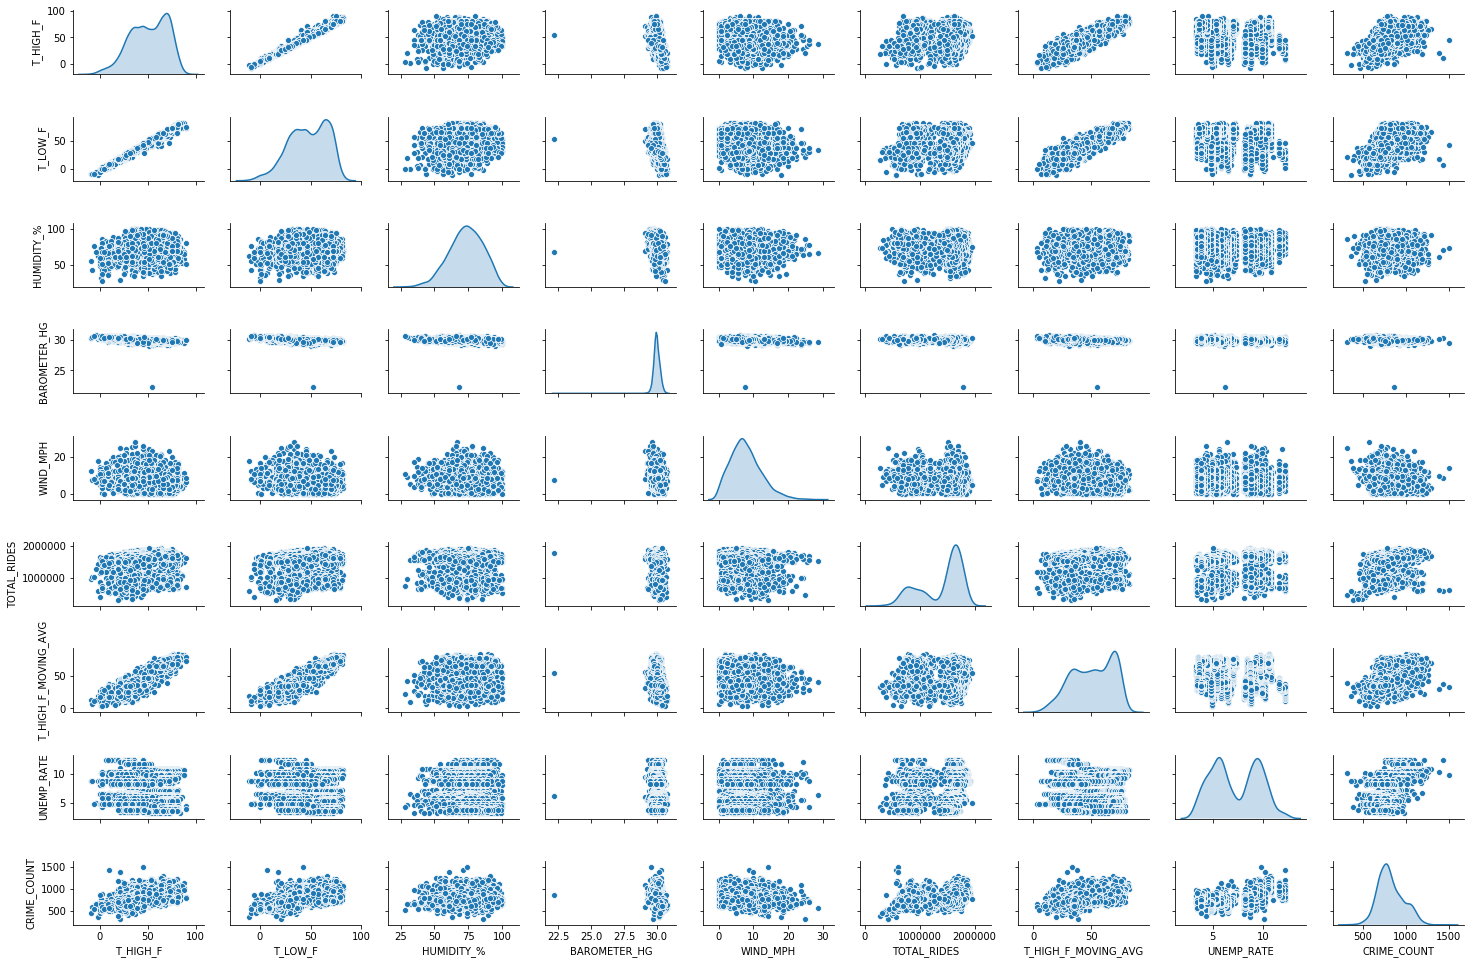

In [13]:
numerical_features = ['T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH','TOTAL_RIDES','T_HIGH_F_MOVING_AVG','UNEMP_RATE','CRIME_COUNT']
sns.pairplot(df_merged[numerical_features],height=1.5, aspect=1.5, diag_kind='kde');

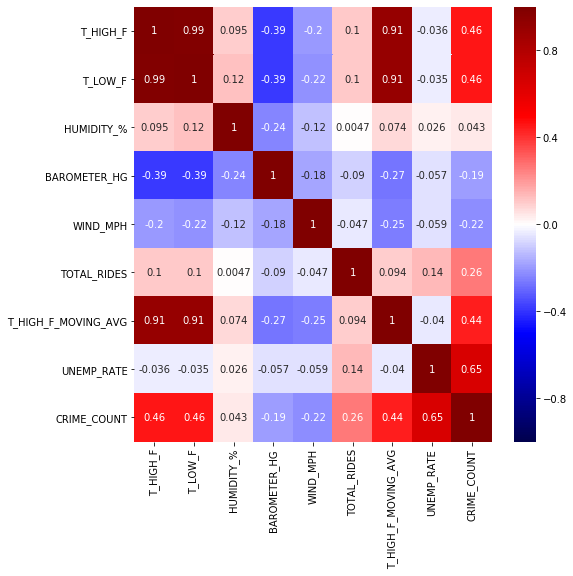

In [8]:
# corr matrix of numerical features
plt.figure(figsize=(8, 8))
sns.heatmap(df_merged[numerical_features].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

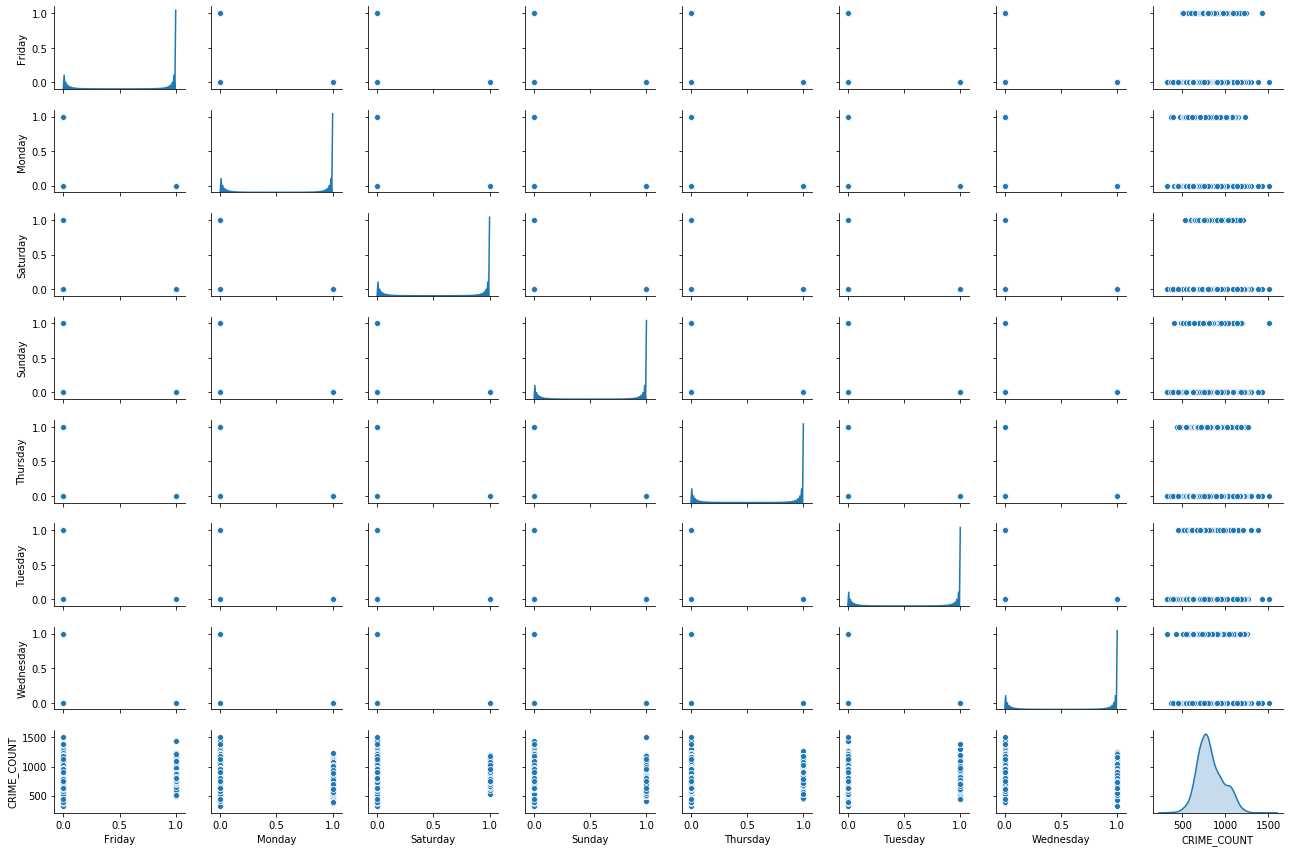

In [114]:
categorical_features_day_name = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday','CRIME_COUNT']
sns.pairplot(df_merged[categorical_features_day_name],height=1.5, aspect=1.5, diag_kind='kde');

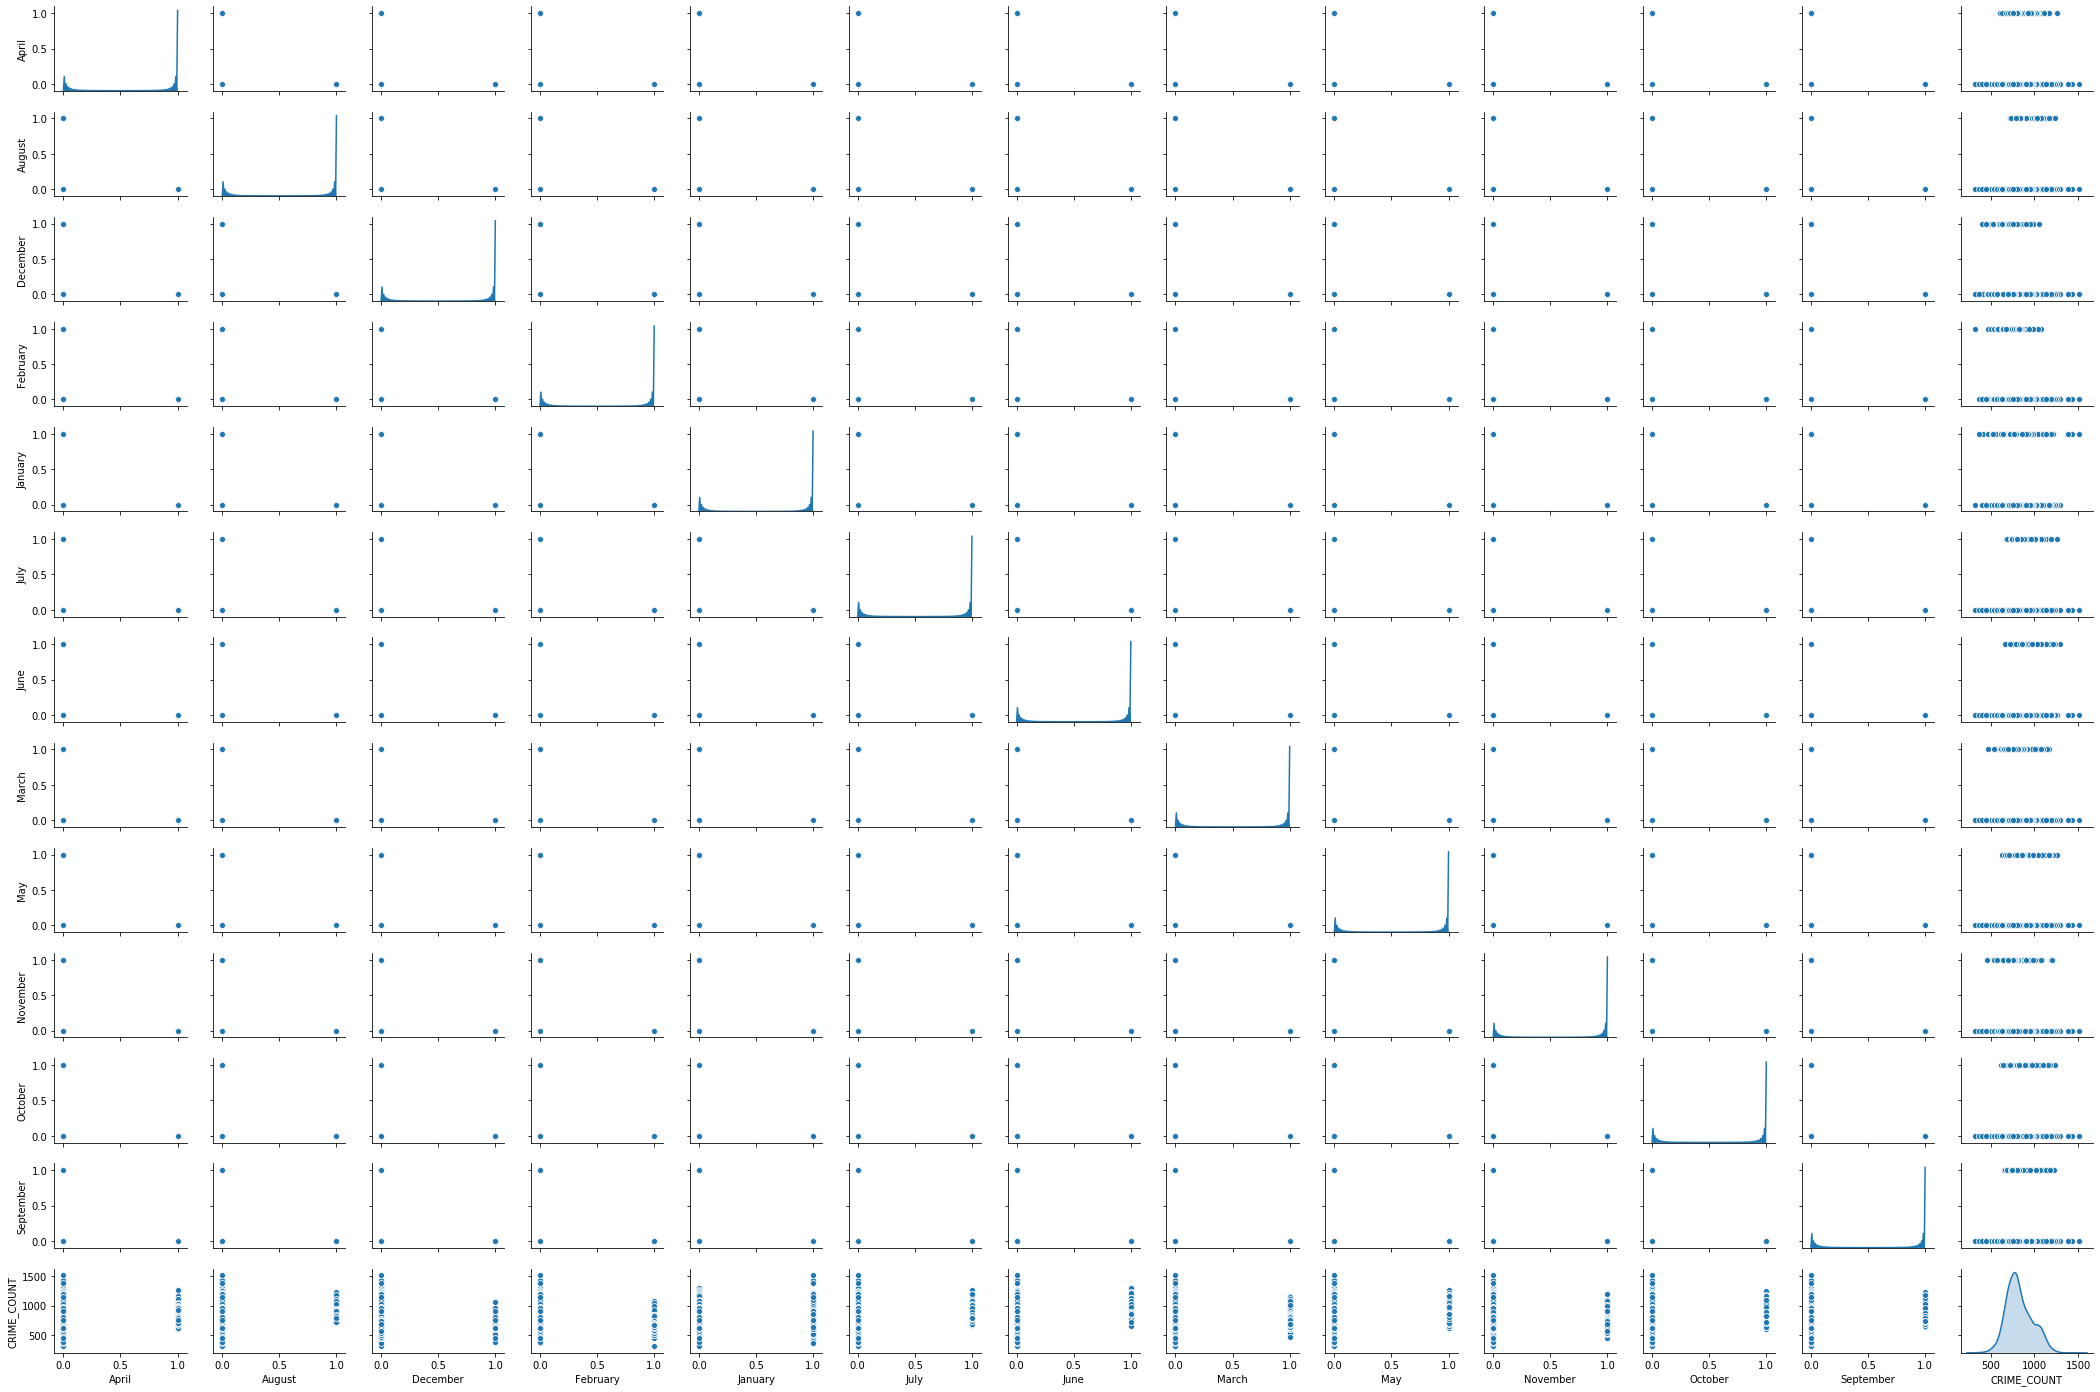

In [115]:
categorical_features_month = ['April', 'August', 'December', 'February', 'January',
       'July', 'June', 'March', 'May', 'November', 'October', 'September','CRIME_COUNT']
sns.pairplot(df_merged[categorical_features_month],height=1.5, aspect=1.5, diag_kind='kde');

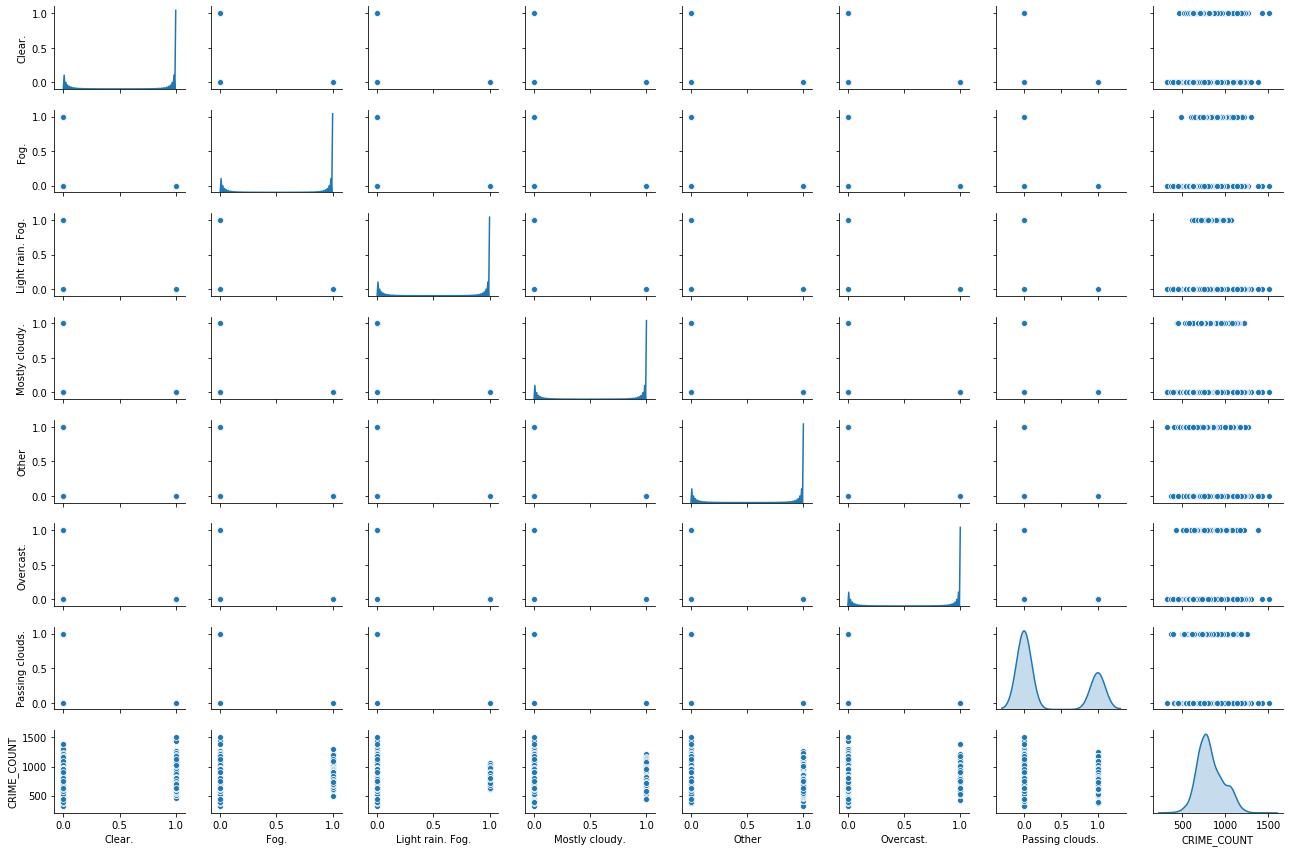

In [116]:
categorical_features_weather = ['Clear.', 'Fog.', 'Light rain. Fog.', 'Mostly cloudy.', 'Other',
       'Overcast.', 'Passing clouds.','CRIME_COUNT']
sns.pairplot(df_merged[categorical_features_weather],height=1.5, aspect=1.5, diag_kind='kde');

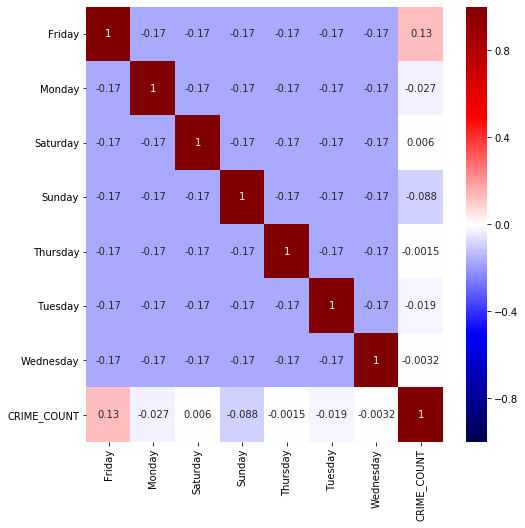

In [119]:
# corr matrix
plt.figure(figsize=(8, 8))
sns.heatmap(df_merged[categorical_features_day_name].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

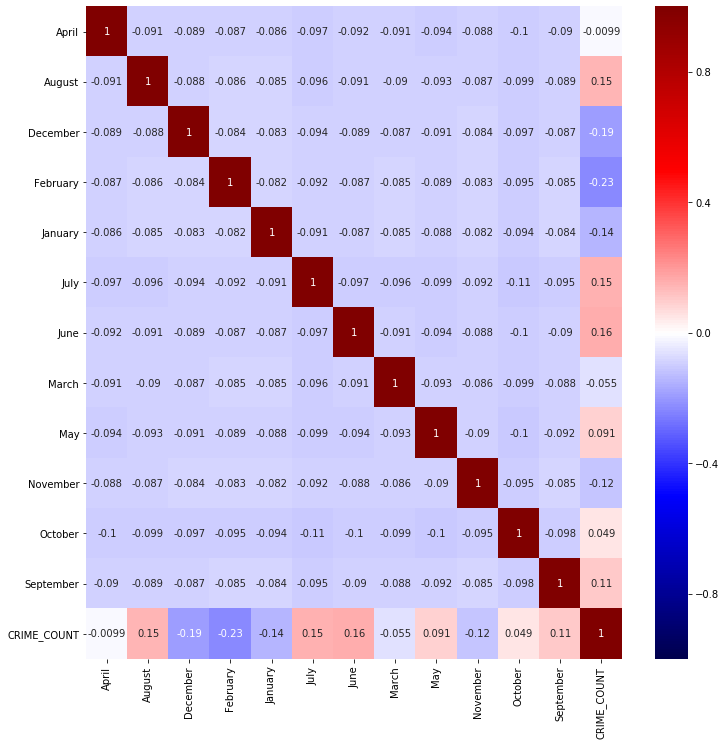

In [122]:
# corr matrix
plt.figure(figsize=(12,12))
sns.heatmap(df_merged[categorical_features_month].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

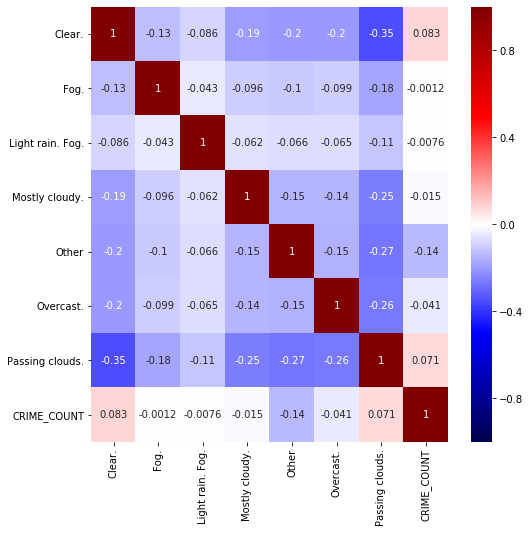

In [124]:
# corr matrix
plt.figure(figsize=(8,8))
sns.heatmap(df_merged[categorical_features_weather].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

#### Add following data to improve the model

Add economical factors (income, job#, ...)  
Add population density

[Factors from FBI](https://ucr.fbi.gov/hate-crime/2011/resources/variables-affecting-crime)  
[Chicago Bus and Rail](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97)  
[Traffic Congestion](https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/77hq-huss)  
[Unemployment & Various Monthly Data](https://www.bls.gov/regions/midwest/il_chicago_msa.htm)

# Linear Regression

**LASSO**:
* _Pro_: great for trimming features and focusing interpretation on a few key ones
* _Con_: risk of discarding features that are actually useful
* 'l1_ratio' = 1 in ElasticNet

**Ridge**:
* _Pro_: great for smoothly handling multicollinearity, very nice when working with sparse features 
* _Con_: will never fully discard features
* 'l1_ratio' = 0 in ElasticNet


#### Graph Functions

In [7]:
def graph_pred_vs_actual(actual,pred,data_type):
    plt.scatter(actual,pred,alpha=.3)
    plt.plot(np.linspace(int(min(pred)),int(max(pred)),int(max(pred))),np.linspace(int(min(pred)),int(max(pred)),int(max(pred))))
    plt.title('Actual vs Pred ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Pred')  
    plt.show()
def graph_residual(actual,residual,data_type):
    plt.scatter(actual,residual,alpha=.3)
    plt.plot(np.linspace(int(min(actual)),int(max(actual)),int(max(actual))),np.linspace(0,0,int(max(actual))))
    plt.title('Actual vs Residual ({} Data)'.format(data_type))
    plt.xlabel('Actual')
    plt.ylabel('Residual')
    plt.show()
        

#### Remove 6 Outlier Points from Target

In [13]:
# mask = ((df_merged['CRIME_COUNT']<df_merged['CRIME_COUNT'].quantile(0.999))
#         &        
#         (df_merged['CRIME_COUNT']>df_merged['CRIME_COUNT'].quantile(0.001)))
# print(len(df_merged)-len(df_merged[mask]),"Rows Removed")
# df_merged = df_merged[mask].copy()

#### Split Data

In [49]:
features_all = list(df_merged.columns)
features_all.remove('CRIME_COUNT')

X = df_merged[features_all]
y = df_merged['CRIME_COUNT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state = 42)

#### Remove Outliners for Numerical Features ('T_HIGH_F',  'T_LOW_F',  'HUMIDITY_%', 'BAROMETER_HG',  'WIND_MPH', 'total_rides') Based on Percentile (HURTS THE MODEL)

In [10]:
# features_base = list(df_merged.columns[0:7])
# features_base.remove('CRIME_COUNT')
# X_train_no_outlier = X_train.copy()
# X_train_no_outlier['CRIME_COUNT'] = y_train.copy()

# for ix,feature in enumerate(features_base):
#     mask = ((X_train_no_outlier[feature]<X_train_no_outlier[feature].quantile(0.98))
#             &        
#             (X_train_no_outlier[feature]>X_train_no_outlier[feature].quantile(0.02)))
#     X_train_no_outlier = X_train_no_outlier[mask].copy()
# print("Total Rows of Data Removed : ",len(X_train)-len(X_train_no_outlier))

# y_train = X_train_no_outlier['CRIME_COUNT'].copy()
# X_train = X_train_no_outlier.drop(columns=['CRIME_COUNT']).copy()


#### Base Model

In [18]:
#Split the data 80/20 cross-validation/test
# Include Categorical features : ['T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH','TOTAL_RIDES','UNEMP_RATE']
features_base = list(df_merged.columns[0:8])
features_base.remove('CRIME_COUNT')

std = StandardScaler()
Xtr = std.fit_transform(X_train[features_base])
Xte = std.transform(X_test[features_base])

base_model = Lasso()
base_model.fit(Xtr,y_train)

base_r2_train = base_model.score(Xtr,y_train)
base_r2_test = base_model.score(Xte,y_test)
base_coef = list(zip(features_base,base_model.coef_))

In [65]:
#Base_R^2_Train :  0.2546924527867718 and Base_R^2_Test :  0.3337184672866654 before moving outlier
print("Base Model")
print("\nBase_R^2_Train : ",base_r2_train)
print("Base_R^2_Test : ",base_r2_test)
print("\nMAE : ",np.mean(np.abs(base_model.predict(Xte)-y_test)))
print("\nCoefficients : ")
for row in base_coef:
    print(row)

Base Model

Base_R^2_Train :  0.6733373787242718
Base_R^2_Test :  0.7027140682440205

MAE :  64.45479153893277

Coefficients : 
('T_HIGH_F', 45.82062524313216)
('T_LOW_F', 19.526820913939)
('HUMIDITY_%', -3.7073111114552946)
('BAROMETER_HG', 0.0)
('WIND_MPH', -10.838539034006782)
('TOTAL_RIDES', 16.12684061071973)
('UNEMP_RATE', 96.55139115496372)


#### Graphs for Base Model

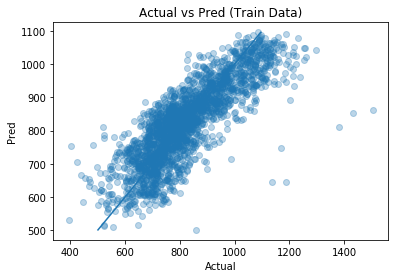

In [20]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_train,base_model.predict(Xtr),'Train')

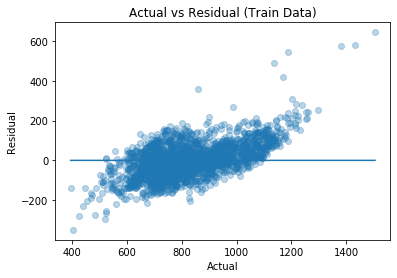

In [21]:
## Residual Plot
graph_residual(y_train,y_train-base_model.predict(Xtr),'Train')

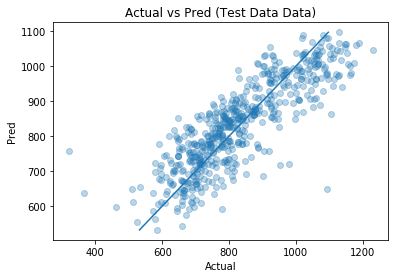

In [25]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,base_model.predict(Xte),'Test Data')

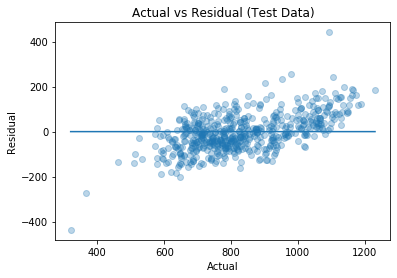

In [26]:
## Residual Plot
graph_residual(y_test,y_test-base_model.predict(Xte),'Test')

#### ElasticNet - RandomGrid - All Features

In [27]:
#Split the data 80/20 cross-validation/test
features_all = list(df_merged.columns)
features_all.remove('CRIME_COUNT')

# Define cross-validation pipelines for lasso and ridge linear regression models
elasticnet_pipeline = Pipeline([
                        ('polynomial',PolynomialFeatures()),
                        ('standard',StandardScaler()),                        
                        ('model',ElasticNet())
                        ])

# # print parameters for lasso & ridge cross-validation pipelines
# print('ElasticNet Params :\n\n',elasticnet_pipeline.get_params().keys(),'\n')

#Define hyperparameters for GridSearchCV & RandomizedSearchCV
alphavec = 10**np.linspace(-2,2,300)
l1vec = np.linspace(0,1,100)
hyperparameters = {'polynomial__degree':[2],
                   'model__alpha':alphavec,
                   'model__l1_ratio':l1vec,
                   'model__max_iter':[2000],
                   #'model__normalize':[True,False],
                   'model__random_state':[209]}
clf_elastic_rand_grid = RandomizedSearchCV(elasticnet_pipeline,
                             param_distributions=hyperparameters,
                             cv=5,
                             random_state=209,
                             scoring='r2',
                             n_iter=30,
                             verbose=0)
clf_elastic_rand_grid.fit(X_train[features_all],y_train);

/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6331.689302163199, tolerance: 4075.844321843575
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5227.9297860227525, tolerance: 3921.4071830167595
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4126.466902328655, tolerance: 3880.2906860893854
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: Con

/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1079671.2998734931, tolerance: 4075.844321843575
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567694.5024839286, tolerance: 3921.4071830167595
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521538.8520247033, tolerance: 3880.2906860893854
  positive)
/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: Con

In [62]:
# R^2 Scores
# R^2 Score (Train Data):  0.5260655537526424 and R^2 Score (Test Data):  0.44061062222772496 before removing outliers
print("RandomizedSearchCV")
print("\nR^2 Score (Train Data): ",clf_elastic_rand_grid.score(X_train[features_all],y_train))
print("R^2 Score (Test Data): ",clf_elastic_rand_grid.score(X_test[features_all],y_test))
print("\nMAE : ",np.mean(np.abs(clf_elastic_rand_grid.predict(X_test[features_all])-y_test)))
print("\nBest params : ",clf_elastic_rand_grid.best_params_)

RandomizedSearchCV

R^2 Score (Train Data):  0.8445360055545827
R^2 Score (Test Data):  0.8169573186475456

MAE :  50.0768694126316

Best params :  {'polynomial__degree': 2, 'model__random_state': 209, 'model__max_iter': 2000, 'model__l1_ratio': 0.9494949494949496, 'model__alpha': 0.04665479882234473}


In [29]:
# Print All Coefficients

# Convert 'x0','x1',.... 'xn' to actual feature names
dict_coeff = dict()
for ix,feature in enumerate(features_all):
    coef = 'x'+str(ix)
    dict_coeff[coef] = feature
elasticnet_coef = clf_elastic_rand_grid.best_estimator_.named_steps.polynomial.get_feature_names()
for ix,coef in enumerate(elasticnet_coef):
    for jx,feature in enumerate(list(dict_coeff.keys())[::-1]):
        elasticnet_coef[ix] = elasticnet_coef[ix].replace(feature,dict_coeff[feature])

print("\nCoefficients : ")
for coeff in list(zip(elasticnet_coef,clf_elastic_rand_grid.best_estimator_.named_steps.model.coef_)):
    print(coeff)


Coefficients : 
('1', 0.0)
('T_HIGH_F', 6.021658551491461)
('T_LOW_F', 5.135736362955387)
('HUMIDITY_%', 0.0)
('BAROMETER_HG', -0.0)
('WIND_MPH', 3.813552177423312)
('TOTAL_RIDES', -0.0)
('UNEMP_RATE', -65.88148011232818)
('T_HIGH_F_MOVING_AVG', 1.428522600255875)
('Friday', 3.7228241934960034)
('Monday', -0.0)
('Saturday', 0.0)
('Sunday', -6.716601731829281)
('Thursday', 0.0)
('Tuesday', -0.7330339535146981)
('Wednesday', 0.0)
('April', -0.5810305152175796)
('August', 0.0)
('December', -1.7113870574367205)
('February', -0.0)
('January', 17.86002343194624)
('July', 7.957846608955713)
('June', 0.0)
('March', -3.862050114808178)
('May', -0.0)
('November', -4.855561172653356)
('October', 0.0)
('September', 0.0)
('Clear.', -0.0)
('Fog.', -0.0)
('Mostly cloudy.', 0.19491073086600239)
('Other', 0.0)
('Overcast.', -0.0)
('Passing clouds.', 0.0)
('T_HIGH_F^2', -0.0)
('T_HIGH_F T_LOW_F', -2.254040380579862)
('T_HIGH_F HUMIDITY_%', -0.0)
('T_HIGH_F BAROMETER_HG', 9.431505805915215)
('T_HIGH_F W

In [30]:
# View Top Coefficients Influencing the Model
elastic_net_coef = pd.DataFrame({'COEF':elasticnet_coef,'COEF_VALUE':clf_elastic_rand_grid.best_estimator_.named_steps.model.coef_}).sort_values(by='COEF_VALUE',ascending=False)

In [33]:
elastic_net_coef[abs(elastic_net_coef['COEF_VALUE'])>20]

,COEF,COEF_VALUE
217,UNEMP_RATE^2,236.197493
201,TOTAL_RIDES December,34.984679
194,TOTAL_RIDES Saturday,30.790255
190,TOTAL_RIDES UNEMP_RATE,27.355908
189,TOTAL_RIDES^2,23.588516
195,TOTAL_RIDES Sunday,22.852465
258,T_HIGH_F_MOVING_AVG June,22.379125
60,T_HIGH_F September,20.072442
204,TOTAL_RIDES July,-21.717573
229,UNEMP_RATE February,-23.261130


#### Graphs for ElasticNet Model

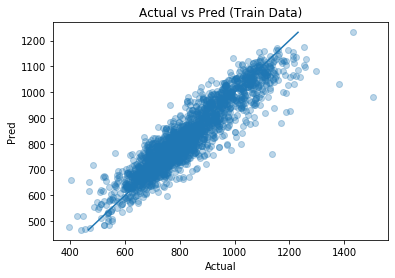

In [18]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_train,clf_elastic_rand_grid.predict(X_train[features_all]),'Train')

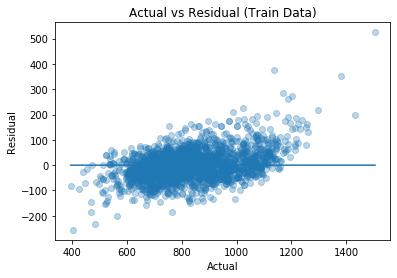

In [19]:
## Residual Plot
graph_residual(y_train,y_train-clf_elastic_rand_grid.predict(X_train[features_all]),'Train')

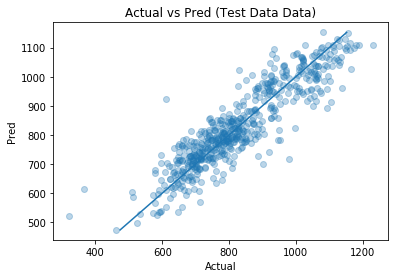

In [20]:
# Plot predicted vs actual 
graph_pred_vs_actual(y_test,clf_elastic_rand_grid.predict(X_test[features_all]),'Test Data')

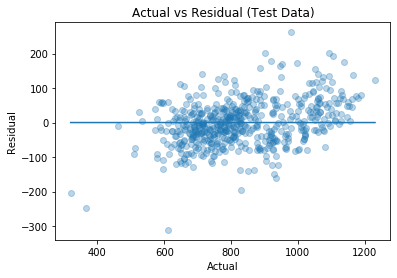

In [21]:
## Residual Plot
graph_residual(y_test,y_test-clf_elastic_rand_grid.predict(X_test[features_all]),'Test')

# Outlier Based on Residual Plot

In [54]:
X_test['RESIDUAL'] = y_test-clf_elastic_rand_grid.predict(X_test[features_all])

/Users/matthewlee/anaconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
X_test = X_test.copy()
X_test['CRIME_COUNT'] = y_test.copy()

In [57]:
X_test.columns

Index(['DATE_TIME_PROCESSED', 'T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%',
       'BAROMETER_HG', 'WIND_MPH', 'TOTAL_RIDES', 'UNEMP_RATE',
       'T_HIGH_F_MOVING_AVG', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'Clear.', 'Fog.', 'Mostly cloudy.', 'Other',
       'Overcast.', 'Passing clouds.', 'RESIDUAL', 'CRIME_COUNT'],
      dtype='object')

In [ ]:
X_test[['DATE_TIME_PROCESSED', 'T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%',
       'BAROMETER_HG', 'WIND_MPH', 'TOTAL_RIDES', 'UNEMP_RATE',
       'T_HIGH_F_MOVING_AVG', 'RESIDUAL', 'CRIME_COUNT']]

In [58]:
X_test[abs(X_test['RESIDUAL'])>200][['DATE_TIME_PROCESSED', 'T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%',
       'BAROMETER_HG', 'WIND_MPH', 'TOTAL_RIDES', 'UNEMP_RATE',
       'T_HIGH_F_MOVING_AVG', 'RESIDUAL', 'CRIME_COUNT']]

,DATE_TIME_PROCESSED,T_HIGH_F,T_LOW_F,HUMIDITY_%,BAROMETER_HG,WIND_MPH,TOTAL_RIDES,UNEMP_RATE,T_HIGH_F_MOVING_AVG,RESIDUAL,CRIME_COUNT
2751,2018-11-01,52.0,52.0,58.0,29.90,9.321,1664628.0,3.5,45.857143,201.281247,902.0
2591,2018-05-01,64.0,57.0,35.0,29.97,9.943,1654457.0,3.4,50.857143,261.667259,978.0
1206,2014-01-06,-2.0,-11.0,63.0,30.16,18.021,580617.0,8.7,19.285714,-248.984205,366.0
1852,2016-01-01,25.0,19.0,67.0,30.25,15.535,623156.0,6.5,42.000000,200.504367,1092.0
278,2011-02-02,21.0,21.0,86.0,29.75,24.857,428521.0,10.1,38.571429,-202.848361,320.0
2171,2017-01-02,36.0,32.0,74.0,30.15,6.836,686663.0,5.8,38.571429,-311.115876,612.0


In [60]:
X_test[['DATE_TIME_PROCESSED', 'T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%',
       'BAROMETER_HG', 'WIND_MPH', 'TOTAL_RIDES', 'UNEMP_RATE',
       'T_HIGH_F_MOVING_AVG', 'RESIDUAL', 'CRIME_COUNT']].describe()

,T_HIGH_F,T_LOW_F,HUMIDITY_%,BAROMETER_HG,WIND_MPH,TOTAL_RIDES,UNEMP_RATE,T_HIGH_F_MOVING_AVG,RESIDUAL,CRIME_COUNT
count,560.000000,560.000000,560.000000,560.000000,560.000000,5.600000e+02,560.000000,560.000000,560.000000,560.000000
mean,52.537500,49.105357,72.816071,30.011750,7.957407,1.415746e+06,7.349821,52.401020,-1.232339,830.869643
std,20.152159,19.784202,11.639490,0.219882,4.500470,3.811230e+05,2.346146,18.608802,65.564835,153.275107
min,-8.000000,-11.000000,35.000000,29.240000,0.000000,4.285210e+05,3.400000,3.142857,-311.115876,320.000000
25%,37.000000,34.000000,65.000000,29.880000,4.971000,1.075809e+06,5.400000,38.000000,-41.504705,713.750000
50%,54.000000,52.000000,73.000000,29.990000,7.457000,1.586935e+06,7.100000,54.785714,-4.839720,807.000000
75%,70.000000,66.000000,81.000000,30.152500,11.185000,1.696251e+06,9.500000,69.428571,37.258565,935.000000
max,88.000000,82.000000,98.000000,30.810000,28.585000,1.926454e+06,12.200000,82.142857,261.667259,1231.000000


# Work Flow

**Goal : Predict Chicago's Daily Total Crime Counts Using Various Indicators**

1. **Download & Preprocess Chicago Crime Data (2001 to Present) [[Source](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2)]**
    * Obtain Daily Total Crime Counts by Aggregating Data    
2. **Scrape Weather Data (2009 to Present) [[Source](https://www.timeanddate.com/weather/usa/chicago/historic)]**
    * Scraped Data (Daily) : Date, Temp(F), Temp(F), Humidity(%), Barometer(Hg), Wind Direction & Intensity(mph)
3. **Initial Feature Engineering & Modeling**
    * Train/Test Split
    * Base Model With Basic Features
        * **Features :** 'T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH'
        * **Results :** Base_R^2_Train :  **0.23** and Base_R^2_Test :  **0.28**
    * ElasticNet with Engineered Features & RandomizedSearchCV
        * **Base Features :** 'T_HIGH_F', 'T_LOW_F', 'HUMIDITY_%', 'BAROMETER_HG', 'WIND_MPH'
        * **Engineered Features (Numerical) :** 'T_HIGH_F_MOVING_AVG'
        * **Engineered Features (Categorical) :**  'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September', 'Clear.', 'Fog.', 'Mostly cloudy.', 'Other', 'Overcast.', 'Passing clouds.'
        * Hyperparameters for Pipeline & RandomizedSearchCV
            * Pipeline
                * PolynomialFeatures()
                    * Degree : [1,2]
                * StandardScaler()
                * ElasticNet
                    * alpha : 10**np.linspace(-2,2,300)
                    * l1_ratio : np.linspace(0,1,100)
            * RandomizedSearchCV
                * cv = 5
                * scoring = r2
        * **Results :** ElasticNet_R^2_Train :  **0.28** and ElasticNet_R^2_Test :  **0.30**
4. **Add Daily Total Ridership Data (2001 to Present) [[Source](https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD)]**
    * Total Daily Ridership (Bus + Rail Boardings)
    * Same as Step 3 with Additional Features
        * **Additional Base Features :** 'TOTAL_RIDES'
    * **Base Model Results :** Base_R^2_Train :  **0.25** and Base_R^2_Test :  **0.33**
    * **ElasticNet Results :** ElasticNet_R^2_Train :  **0.35** and ElasticNet_R^2_Test :  **0.41**
5. **Add Unemployment Rate Data (2001 to Present) [[Source](https://data.bls.gov/timeseries/LAUMT171698000000004?amp%253bdata_tool=XGtable&output_view=data&include_graphs=true)]**
    * Monthly Unemployment Rate
    * Same as Step 3 with Additional Features
        * **Additional Base Features :** 'UNEMP_RATE'
    * **Base Model Results :** Base_R^2_Train :  **0.67** and Base_R^2_Test :  **0.70**
    * **ElasticNet Results :** ElasticNet_R^2_Train :  **0.84** and ElasticNet_R^2_Test :  **0.82**
6. **Run with Just Unemployment Rate**
    * **Base Model Results :** Base_R^2_Train :  **0.43** and Base_R^2_Test :  **0.40**
    * **ElasticNet Results :** ElasticNet_R^2_Train :  **0.46** and ElasticNet_R^2_Test :  **0.44**